In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.4 MB/s eta 0:00:00


In [2]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.7 MB/s eta 0:00:00


In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c widsdatathon2023

 93% 189M/203M [00:01<00:00, 184MB/s]
100% 203M/203M [00:01<00:00, 196MB/s]


In [8]:
! unzip /content/widsdatathon2023.zip

Archive:  /content/widsdatathon2023.zip
  inflating: sample_solution.csv     
  inflating: test_data.csv           
  inflating: train_data.csv          


In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
#from skopt import BayesSearchCV
#from skopt.space import Real, Integer
import gc
import lightgbm as lgb
import optuna
%matplotlib inline
print("Libraries imported")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Libraries imported


In [10]:
from scipy import stats

# Loading data

## Load the data of train and test set

In [11]:
cc_train = pd.read_csv('/content/train_data.csv')
cc_test = pd.read_csv('/content/test_data.csv')
cc_sample = pd.read_csv('/content/sample_solution.csv')

## Reduce the memory usage of the dataset
[Reduce DF size](https://www.kaggle.com/competitions/widsdatathon2023/discussion/376649)

In [12]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [13]:
cc_train = reduce_mem_usage(cc_train)

Mem. usage decreased to 352.24 Mb (50.1% reduction)


# Exploratary Data Analysis

## Overview of the dataset

In [14]:
# Save into a new dataset
train_df = cc_train.copy()
test_df = cc_test.copy()

In [15]:
print(train_df.shape)
print(test_df.shape)

(375734, 246)
(31354, 245)


## Visualise the time gap between the train and the test data

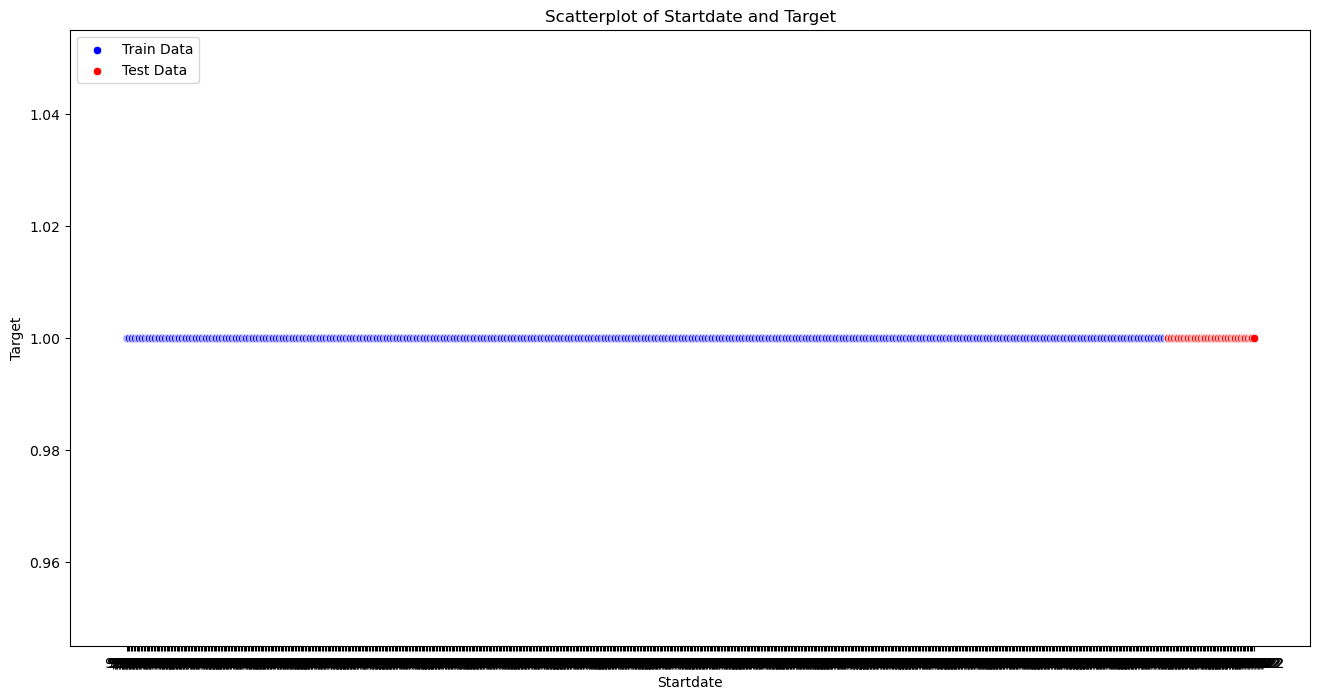

In [ ]:
# create a scatterplot using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(16, 8))
sb.scatterplot(x=train_df.startdate, y=1, color='blue', label='Train Data', ax=ax)
sb.scatterplot(x=test_df.startdate, y=1, color='red', label='Test Data', ax=ax)

# add labels and a title to the plot
ax.set_title('Scatterplot of Startdate and Target')
ax.set_xlabel('Startdate')
ax.set_ylabel('Target')
ax.legend(loc='upper left')

# display the plot
plt.show()

In [ ]:
train_df["startdate"].describe()

count     375734
unique       731
top       9/1/14
freq         514
Name: startdate, dtype: object

In [ ]:
print("train date from {} to {}.".format(train_df["startdate"].unique()[0],  train_df["startdate"].unique()[-1]))

train date from 9/1/14 to 8/31/16.


In [ ]:
test_df["startdate"].describe()

count       31354
unique         61
top       11/1/22
freq          514
Name: startdate, dtype: object

In [ ]:
print("test date from {} to {}.".format(test_df["startdate"].unique()[0],  test_df["startdate"].unique()[-1]))

test date from 11/1/22 to 12/31/22.


**Based on the graph above the train data was from 2014 - 2016 and the test data is from 2022. There is a big time gap between the train and test data.**

## Analyising the distribution of values in both the train and test dataset

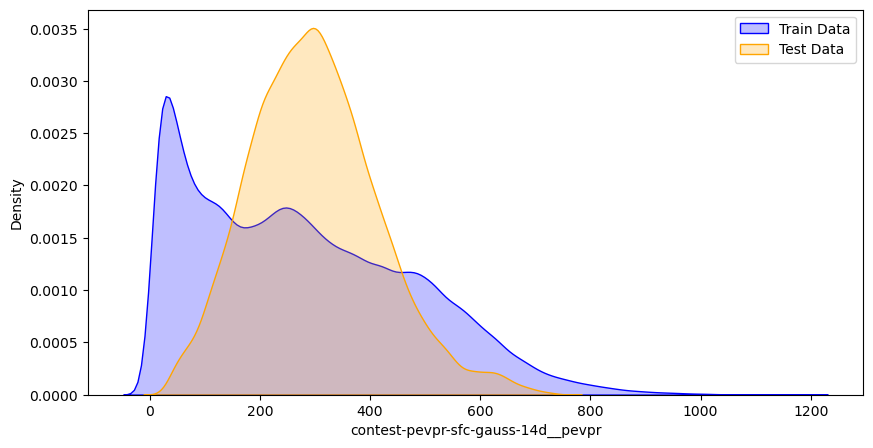

In [ ]:
def train_test_dist(train, test):
    fig, ax = plt.subplots(figsize = (10, 5))
    sb.kdeplot(data=train,  color='blue', fill=True, ax=ax, label="Train Data")
    sb.kdeplot(data=test, color='orange', fill=True, ax=ax, label="Test Data")
    plt.legend()
    plt.show()
    
train_target = cc_train['contest-pevpr-sfc-gauss-14d__pevpr']
test_target = cc_test['contest-pevpr-sfc-gauss-14d__pevpr']
train_test_dist(train_target, test_target)

## Visualizing the target variable
> contest-tmp2m-14d__tmp2m

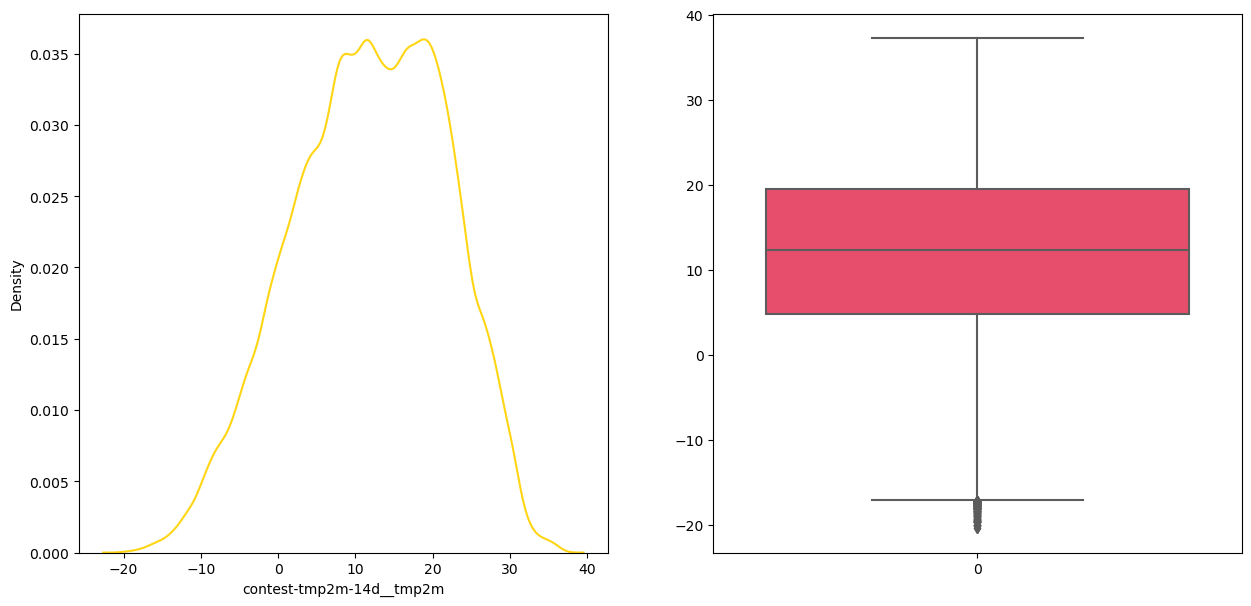

In [ ]:
def target_var_visualized():
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  sb.kdeplot(cc_train['contest-tmp2m-14d__tmp2m'], color = "#ffd514")
  plt.subplot(122)
  sb.boxplot(data=cc_train['contest-tmp2m-14d__tmp2m'], color = "#ff355d")
target_var_visualized()

## Displaying the distribution of the target variable in the train and test

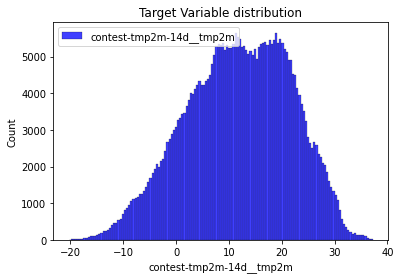

In [27]:
def histogram_plot(data, label, title):
    sb.histplot(data, color='blue', label=label)
    plt.legend()
    plt.title(title)
    plt.show()
histogram_plot(data=cc_train['contest-tmp2m-14d__tmp2m'], label="contest-tmp2m-14d__tmp2m", title="Target Variable distribution")

**The target variable is not in the test dataset**

# Data Preprocessing

## Location features

In [16]:
def location_feature(train, test):
    # Reference: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14
    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)
    
    train_and_test = pd.concat([train, test], axis=0)
    train_and_test['loc_group'] = train_and_test.groupby(['lat', 'lon']).ngroup()
    print(f'{train_and_test.loc_group.nunique()} unique locations')
    
    train = train_and_test.iloc[:len(train)]
    test = train_and_test.iloc[len(train):].drop(target, axis=1)
    
    return train, test

## Encoding categorical variables

In [17]:
def cat_encode(train, test):
    # encoding the categorical feature in the train and test data set
    # using OneHotEncoder
    ohe = OneHotEncoder()
    train_encoded = ohe.fit_transform(train[['climateregions__climateregion']])
    test_encoded = ohe.transform(test[['climateregions__climateregion']])
    
    train = train.drop(['climateregions__climateregion'], axis=1)
    test = test.drop(['climateregions__climateregion'], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

In [58]:
def categorical_label_encode(train, test, cat_cols):
    le = LabelEncoder()
    for col in cat_cols:
        train[col] = le.fit_transform(train[[col]])
        test[col] = le.transform(test[[col]])
    return train, test

## Two ways to fill na: By Mean or Interpolation

In [18]:
def fill_na_rows(dataset):
    # Find the columns with missing values
    columns_with_missing_values = dataset.columns[dataset.isnull().any()].tolist()
    
    # Impute the missing values with the mean value of that column
    for col in columns_with_missing_values:
        dataset[col].fillna(dataset[col].mean(), inplace=True)
        
    return dataset

In [19]:
def linear_interpolation_by_level(df, feature):
    
    """Function linear interpolation for the dataset considering the levels of a categorical feature"""
    
    #Initializing dataframe
    imputation_val = pd.DataFrame()
    #List of all locations
    level_list = df[feature].unique().tolist()
    
    #Function
    for i in level_list:
        #Dataframe
        dataf = df[df[feature]==i].interpolate(method='linear')
        #Appending
        imputation_val = pd.concat([imputation_val,dataf])
    
    return imputation_val

## Create new features on datetime

In [20]:
def create_new_feat(dataset):
    dataset['year']=pd.DatetimeIndex(dataset['startdate']).year 
    dataset['month']=pd.DatetimeIndex(dataset['startdate']).month 
    dataset['day']=pd.DatetimeIndex(dataset['startdate']).day
    return dataset

## Transformation

In [ ]:
def yeojohnson_transform(train_data, test_data):
    """yeojohnson transformation for all train and test dataset
    Note that: you must drop out 'index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion'
    before using yeojohnson transformation"""
    
    # Get the numeric columns
    numeric_cols = train_data.select_dtypes(include="number").columns.tolist()

    # Loop over each column in the training set
    lambda_values = {}
    transformed_train_data = pd.DataFrame()
    for col in numeric_cols:
        # Apply yeojohnson transformation on training set
        transformed_col, lambda_value = stats.yeojohnson(train_data[col])
        # Store the lambda value for each column
        lambda_values[col] = lambda_value
        # Store the transformed column in a new DataFrame
        transformed_train_data[col] = transformed_col

    # Apply yeojohnson transformation on test set using lambda values from training set
    transformed_test_data = pd.DataFrame()
    for col in numeric_cols:
        transformed_test_data[col] = stats.yeojohnson(test_data[col], lambda_values[col])
        
    return transformed_train_data, transformed_test_data

In [21]:
def MinMaxScaler_transform(train_data, test_data):
        # Get the numeric columns
    numeric_cols = train_data.select_dtypes(include="number").columns.tolist()

    # Apply MinMaxScaler on training set
    scaler = MinMaxScaler()
    scaler.fit(train_data[numeric_cols])
    transformed_train_data = pd.DataFrame(scaler.transform(train_data[numeric_cols]), columns=numeric_cols)

    # Apply MinMaxScaler on test set using parameters from training set
    transformed_test_data = pd.DataFrame(scaler.transform(test_data[numeric_cols]), columns=numeric_cols)
    
    return transformed_train_data, transformed_test_data

In [22]:
def StandardScaler_transform(train_data, test_data):
    # Get the numeric columns
    numeric_cols = train_data.select_dtypes(include="number").columns.tolist()

    # Apply StandardScaler on training set
    scaler = StandardScaler()
    scaler.fit(train_data[numeric_cols])
    transformed_train_data = pd.DataFrame(scaler.transform(train_data[numeric_cols]), columns=numeric_cols)

    # Apply StandardScaler on test set using parameters from training set
    transformed_test_data = pd.DataFrame(scaler.transform(test_data[numeric_cols]), columns=numeric_cols)
    return transformed_train_data, transformed_test_data

In [61]:
def feature_scale(train, test):
    scaler = MinMaxScaler()
    train_ = scaler.fit_transform(train)
    test_ = scaler.transform(test)
    train = pd.DataFrame(train_, columns = train.columns)
    test = pd.DataFrame(test_, columns = test.columns)
    return train, test

In [46]:
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [24]:
target="contest-tmp2m-14d__tmp2m"

In [62]:
def feature_engineering(origin_train, origin_test):
    train, test = location_feature(origin_train, origin_test)
    
    train = linear_interpolation_by_level(train, "lat")
    #train = fill_na_rows(train)

    train = create_new_feat(train)
    test = create_new_feat(test)

    train, test =  categorical_label_encode(train, test, cat_cols=['climateregions__climateregion'])
   
    #train, test = cat_encode(train, test)
    
    #irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion']
    #features = [col for col in train.columns if col not in irrelevant_cols]

    to_drop = identify_correlated(train.copy(), threshold=.85)
    drop_cols = ['index', 'startdate', target]
    drop_cols.extend(to_drop)
    features = [col for col in train.columns if col not in drop_cols]
   
    X = train[features]
    X_test = test[features]
    y = train['contest-tmp2m-14d__tmp2m']
    
    #X, X_test = StandardScaler_transform(X, X_test)
    #X, X_test = MinMaxScaler_transform(X, X_test)
    X, X_test = feature_scale(X, X_test)
    
    return X, y, X_test

target="contest-tmp2m-14d__tmp2m"

In [63]:
X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())

1026 unique locations


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


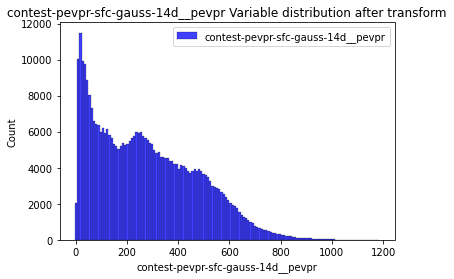

In [28]:
histogram_plot(data=cc_train['contest-pevpr-sfc-gauss-14d__pevpr'], label="contest-pevpr-sfc-gauss-14d__pevpr", title="contest-pevpr-sfc-gauss-14d__pevpr Variable distribution after transform")

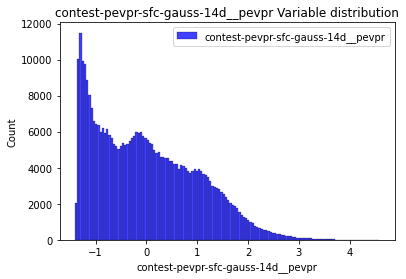

In [29]:
histogram_plot(data=X['contest-pevpr-sfc-gauss-14d__pevpr'], label="contest-pevpr-sfc-gauss-14d__pevpr", title="contest-pevpr-sfc-gauss-14d__pevpr Variable distribution")

## Checking correlation

In [ ]:
# plotting correlation heatmap
#dataplot = sb.heatmap(cc_train.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
#plt.show()

In [26]:
train_correlation = cc_train.corr()

In [27]:
train_correlation_thr_below005 = train_correlation[np.abs(train_correlation) < 0.05]

In [28]:
low_correl = []
for i in range(244):
    for j in range(244):
        if not np.isnan(train_correlation_thr_below005.iloc[i, j]) and train_correlation_thr_below005.iloc[i, j] != 1:
            if train_correlation_thr_below005.columns[i] == "contest-tmp2m-14d__tmp2m" or train_correlation_thr_below005.index[j] == "contest-tmp2m-14d__tmp2m":
                print(train_correlation_thr_below005.columns[i],train_correlation_thr_below005.index[j], train_correlation_thr_below005.iloc[i, j])
                low_correl.append(train_correlation_thr_below005.columns[i])
                low_correl.append(train_correlation_thr_below005.index[j])
low_correl_unique = np.unique(low_correl)

nmme-prate-34w__cfsv2 contest-tmp2m-14d__tmp2m 0.01449332607173707
nmme-prate-34w__nasa contest-tmp2m-14d__tmp2m 0.002205549017090327
nmme0-prate-56w__nmme0mean contest-tmp2m-14d__tmp2m 0.00319290989978141
nmme0-prate-34w__cancm30 contest-tmp2m-14d__tmp2m 0.04122269189361413
nmme0-prate-34w__cancm40 contest-tmp2m-14d__tmp2m -0.003955405502962272
nmme0-prate-34w__gfdl0 contest-tmp2m-14d__tmp2m 0.010788422403246593
nmme0-prate-34w__nmme0mean contest-tmp2m-14d__tmp2m -0.04919133323287327
contest-tmp2m-14d__tmp2m nmme-prate-34w__cfsv2 0.01449332607173707
contest-tmp2m-14d__tmp2m nmme-prate-34w__nasa 0.002205549017090327
contest-tmp2m-14d__tmp2m nmme0-prate-56w__nmme0mean 0.00319290989978141
contest-tmp2m-14d__tmp2m nmme0-prate-34w__cancm30 0.04122269189361413
contest-tmp2m-14d__tmp2m nmme0-prate-34w__cancm40 -0.003955405502962272
contest-tmp2m-14d__tmp2m nmme0-prate-34w__gfdl0 0.010788422403246593
contest-tmp2m-14d__tmp2m nmme0-prate-34w__nmme0mean -0.04919133323287327
contest-tmp2m-14d__t

In [36]:
low_correl_unique = list(low_correl_unique)
low_correl_unique.remove("contest-tmp2m-14d__tmp2m")
print(len(low_correl_unique))
low_correl_unique

35


['nmme-prate-34w__cfsv2',
 'nmme-prate-34w__nasa',
 'nmme-prate-56w__cfsv2',
 'nmme-prate-56w__nasa',
 'nmme0-prate-34w__cancm30',
 'nmme0-prate-34w__cancm40',
 'nmme0-prate-34w__gfdl0',
 'nmme0-prate-34w__nmme0mean',
 'nmme0-prate-56w__nmme0mean',
 'wind-hgt-10-2010-6',
 'wind-hgt-10-2010-8',
 'wind-hgt-100-2010-3',
 'wind-hgt-100-2010-4',
 'wind-hgt-100-2010-5',
 'wind-hgt-100-2010-8',
 'wind-hgt-850-2010-10',
 'wind-hgt-850-2010-4',
 'wind-hgt-850-2010-8',
 'wind-uwnd-250-2010-10',
 'wind-uwnd-250-2010-13',
 'wind-uwnd-250-2010-14',
 'wind-uwnd-250-2010-6',
 'wind-uwnd-250-2010-7',
 'wind-uwnd-925-2010-17',
 'wind-uwnd-925-2010-19',
 'wind-uwnd-925-2010-3',
 'wind-vwnd-250-2010-15',
 'wind-vwnd-250-2010-20',
 'wind-vwnd-250-2010-6',
 'wind-vwnd-250-2010-8',
 'wind-vwnd-925-2010-11',
 'wind-vwnd-925-2010-14',
 'wind-vwnd-925-2010-17',
 'wind-vwnd-925-2010-6',
 'wind-vwnd-925-2010-8']

In [37]:
train_correlation_thr_099 = train_correlation[np.abs(train_correlation) > 0.99]
#train_correlation_thr_099

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
index,1.000000,0.995633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,0.995633,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lon,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contest-pevpr-sfc-gauss-14d__pevpr,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmme0-tmp2m-34w__cancm30,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind-vwnd-925-2010-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
wind-vwnd-925-2010-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
wind-vwnd-925-2010-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
wind-vwnd-925-2010-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [38]:
features_to_drop = []
for i in range(244):
    for j in range(244):
        if not np.isnan(train_correlation_thr_099.iloc[i, j]) and train_correlation_thr_099.iloc[i, j] != 1:
            if train_correlation_thr_099.columns[i] != "contest-tmp2m-14d__tmp2m" and train_correlation_thr_099.index[j] != "contest-tmp2m-14d__tmp2m":
                # print(train_correlation_thr_099.columns[i],train_correlation_thr_099.index[j], train_correlation_thr_099.iloc[i, j])
                features_to_drop.append(train_correlation_thr_099.columns[i])
                features_to_drop.append(train_correlation_thr_099.index[j])
features_to_drop_unique = np.unique(features_to_drop)

In [39]:
features_to_drop_unique

array(['cancm30', 'ccsm40', 'cfsv20', 'gfdlflora0', 'gfdlflorb0', 'index',
       'lat', 'nmme-prate-34w__nmmemean', 'nmme-prate-56w__nmmemean',
       'nmme-tmp2m-34w__cancm3', 'nmme-tmp2m-34w__cancm4',
       'nmme-tmp2m-34w__ccsm4', 'nmme-tmp2m-34w__cfsv2',
       'nmme-tmp2m-34w__gfdl', 'nmme-tmp2m-34w__gfdlflora',
       'nmme-tmp2m-34w__gfdlflorb', 'nmme-tmp2m-34w__nasa',
       'nmme-tmp2m-34w__nmmemean', 'nmme-tmp2m-56w__cancm3',
       'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm4',
       'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl',
       'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb',
       'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean',
       'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__ccsm40',
       'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0',
       'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__nmme0mean',
       'nmme0mean'], dtype='<U27')

In [40]:
len(features_to_drop_unique)

34

In [41]:
train_correlation_thr_08 = train_correlation[np.abs(train_correlation) > 0.8]
#train_correlation_thr_08

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
index,1.000000,0.995633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,0.995633,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lon,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contest-pevpr-sfc-gauss-14d__pevpr,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmme0-tmp2m-34w__cancm30,NaN,NaN,NaN,NaN,1.0,0.989678,0.984421,0.982819,0.97741,0.97104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind-vwnd-925-2010-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
wind-vwnd-925-2010-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
wind-vwnd-925-2010-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
wind-vwnd-925-2010-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [42]:
features_have_to_keep = []
for i in range(244):
    for j in range(244):
        if not np.isnan(train_correlation_thr_08.iloc[i, j]) and train_correlation_thr_08.iloc[i, j] != 1:
            if train_correlation_thr_08.columns[i] == "contest-tmp2m-14d__tmp2m" or train_correlation_thr_08.index[j] == "contest-tmp2m-14d__tmp2m":
                #print(train_correlation_thr_08.columns[i],train_correlation_thr_08.index[j], train_correlation_thr_08.iloc[i, j])
                features_have_to_keep.append(train_correlation_thr_08.columns[i])
                features_have_to_keep.append(train_correlation_thr_08.index[j])
features_have_to_keep_unique = np.unique(features_have_to_keep)

In [43]:
features_have_to_keep_unique

array(['contest-pevpr-sfc-gauss-14d__pevpr', 'contest-tmp2m-14d__tmp2m',
       'contest-wind-h100-14d__wind-hgt-100',
       'contest-wind-h500-14d__wind-hgt-500', 'nmme-tmp2m-34w__cancm3',
       'nmme-tmp2m-34w__cancm4', 'nmme-tmp2m-34w__ccsm3',
       'nmme-tmp2m-34w__ccsm4', 'nmme-tmp2m-34w__cfsv2',
       'nmme-tmp2m-34w__gfdl', 'nmme-tmp2m-34w__gfdlflora',
       'nmme-tmp2m-34w__gfdlflorb', 'nmme-tmp2m-34w__nasa',
       'nmme-tmp2m-34w__nmmemean', 'nmme-tmp2m-56w__cancm3',
       'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3',
       'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2',
       'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora',
       'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa',
       'nmme-tmp2m-56w__nmmemean', 'nmme0-tmp2m-34w__cancm30',
       'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30',
       'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20',
       'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__gfdlflora0',
       'nmme0-tmp2m-34w__gfd

In [44]:
len(features_have_to_keep_unique)

38

In [45]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
features_to_keep = intersection(features_to_drop_unique, features_have_to_keep_unique)

features_to_drop_v1 = []
for feat in features_to_drop_unique:
    if feat in features_to_keep:
        continue
    else:
        features_to_drop_v1.append(feat)
        
print(len(features_to_drop_v1))
features_to_drop_v1.remove("index")
features_to_drop_v1

10


['cancm30',
 'ccsm40',
 'cfsv20',
 'gfdlflora0',
 'gfdlflorb0',
 'lat',
 'nmme-prate-34w__nmmemean',
 'nmme-prate-56w__nmmemean',
 'nmme0mean']

In [46]:
for feat in low_correl_unique:
  features_to_drop_v1.append(feat)
len(features_to_drop_v1)
features_to_drop_v1

['cancm30',
 'ccsm40',
 'cfsv20',
 'gfdlflora0',
 'gfdlflorb0',
 'lat',
 'nmme-prate-34w__nmmemean',
 'nmme-prate-56w__nmmemean',
 'nmme0mean',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__nasa',
 'nmme-prate-56w__cfsv2',
 'nmme-prate-56w__nasa',
 'nmme0-prate-34w__cancm30',
 'nmme0-prate-34w__cancm40',
 'nmme0-prate-34w__gfdl0',
 'nmme0-prate-34w__nmme0mean',
 'nmme0-prate-56w__nmme0mean',
 'wind-hgt-10-2010-6',
 'wind-hgt-10-2010-8',
 'wind-hgt-100-2010-3',
 'wind-hgt-100-2010-4',
 'wind-hgt-100-2010-5',
 'wind-hgt-100-2010-8',
 'wind-hgt-850-2010-10',
 'wind-hgt-850-2010-4',
 'wind-hgt-850-2010-8',
 'wind-uwnd-250-2010-10',
 'wind-uwnd-250-2010-13',
 'wind-uwnd-250-2010-14',
 'wind-uwnd-250-2010-6',
 'wind-uwnd-250-2010-7',
 'wind-uwnd-925-2010-17',
 'wind-uwnd-925-2010-19',
 'wind-uwnd-925-2010-3',
 'wind-vwnd-250-2010-15',
 'wind-vwnd-250-2010-20',
 'wind-vwnd-250-2010-6',
 'wind-vwnd-250-2010-8',
 'wind-vwnd-925-2010-11',
 'wind-vwnd-925-2010-14',
 'wind-vwnd-925-2010-17',
 'wind-

In [47]:
print(len(features_to_drop_v1))

44


In [29]:
# from feature importance
features_to_drop_v2 = ['wind-vwnd-250-2010-18', 'wind-hgt-100-2010-3',
       'wind-hgt-100-2010-4', 'wind-uwnd-925-2010-17',
       'wind-vwnd-250-2010-14', 'icec-2010-8', 'sst-2010-2',
       'wind-uwnd-250-2010-2', 'icec-2010-3', 'wind-uwnd-250-2010-20',
       'wind-uwnd-925-2010-6', 'wind-uwnd-250-2010-17', 'gfdlflorb0',
       'elevation__elevation', 'wind-hgt-500-2010-5']

In [30]:
cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v2, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v2, axis=1))
#print("Dropped features that are highly correlated")
print("Drop according to feature importances")

Drop according to feature importances


In [64]:
X_train, X_test_tts, y_train, y_test = train_test_split(X.copy(), y, test_size=0.33, random_state=42)
print("Split the dataset for training successfully")

Split the dataset for training successfully


In [31]:
#X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)
#print("Split the dataset for training successfully")

Split the dataset for training successfully


In [65]:
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_test_tts.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 158)    |   Val_shape: (123993, 158)    |   Test_shape: (31354, 158)


In [79]:
X_train.columns

Index(['lon', 'contest-pevpr-sfc-gauss-14d__pevpr',
       'contest-rhum-sig995-14d__rhum', 'nmme0-prate-34w__ccsm30',
       'nmme0-prate-34w__gfdl0', 'nmme0-prate-34w__nasa0',
       'contest-slp-14d__slp', 'contest-wind-vwnd-925-14d__wind-vwnd-925',
       'nmme-prate-56w__ccsm3', 'nmme-prate-56w__nasa',
       ...
       'wind-vwnd-925-2010-15', 'wind-vwnd-925-2010-16',
       'wind-vwnd-925-2010-17', 'wind-vwnd-925-2010-18',
       'wind-vwnd-925-2010-19', 'wind-vwnd-925-2010-20', 'loc_group', 'year',
       'month', 'day'],
      dtype='object', length=158)

# MODELING

In [ ]:
X_train.sort_values()

In [32]:
import time

## Random Forest

In [ ]:
start = time.time()
# Train the Random Forest Regressor
params = {
    'n_estimators': 500,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True
}
regr_rfr = RandomForestRegressor(**params)
regr_rfr.fit(X_train, y_train)
end = time.time()
print("train time: ", end - start)
# make predictions on the test data
y_pred_rfr = regr_rfr.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("RMSE:", rmse)

In [ ]:
cc_test_pred = regr_rfr.predict(cc_test_reduced)

In [ ]:
cc_test_copy[target] = cc_test_pred
cc_test_copy[[target,"index"]].to_csv("rfrpredictions_mxb_250223_version1.csv",index = False)

## CatBoost

In [ ]:
reg_catb  = CatBoostRegressor(n_estimators= 8000, eval_metric= 'RMSE', learning_rate=0.15, random_seed= 1234)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)

0:	learn: 8.5801828	test: 8.5801828	test1: 8.5744677	best: 8.5744677 (0)	total: 461ms	remaining: 1h 1m 24s
100:	learn: 1.1504919	test: 1.1504919	test1: 1.1571067	best: 1.1571067 (100)	total: 31.1s	remaining: 40m 31s
200:	learn: 0.9157486	test: 0.9157486	test1: 0.9275274	best: 0.9275274 (200)	total: 1m 2s	remaining: 40m 29s
300:	learn: 0.7957813	test: 0.7957813	test1: 0.8106864	best: 0.8106864 (300)	total: 1m 39s	remaining: 42m 37s
400:	learn: 0.7195237	test: 0.7195237	test1: 0.7361504	best: 0.7361504 (400)	total: 2m 10s	remaining: 41m 20s
500:	learn: 0.6631628	test: 0.6631628	test1: 0.6819144	best: 0.6819144 (500)	total: 2m 40s	remaining: 39m 58s
600:	learn: 0.6153352	test: 0.6153352	test1: 0.6357375	best: 0.6357375 (600)	total: 3m 11s	remaining: 39m 15s
700:	learn: 0.5795834	test: 0.5795834	test1: 0.6015719	best: 0.6015719 (700)	total: 3m 40s	remaining: 38m 20s
800:	learn: 0.5494256	test: 0.5494256	test1: 0.5728597	best: 0.5728597 (800)	total: 4m 10s	remaining: 37m 28s
900:	learn: 0.5

In [ ]:
X_test_prediction_cat = reg_catb.predict(X_test_tts)

In [ ]:
#error on test dataset

score = np.sqrt(mean_squared_error(y_test, X_test_prediction_cat))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.23


### Ver 2

In [ ]:
reg_catb  = CatBoostRegressor(n_estimators= 10000, eval_metric= 'RMSE', learning_rate=0.1, random_seed= 1234)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)

0:	learn: 9.0355720	test: 9.0355720	test1: 9.0299495	best: 9.0299495 (0)	total: 349ms	remaining: 58m 5s
100:	learn: 1.3560611	test: 1.3560611	test1: 1.3571136	best: 1.3571136 (100)	total: 28s	remaining: 45m 41s
200:	learn: 1.0549009	test: 1.0549009	test1: 1.0579497	best: 1.0579497 (200)	total: 55.7s	remaining: 45m 15s
300:	learn: 0.9025142	test: 0.9025142	test1: 0.9082231	best: 0.9082231 (300)	total: 1m 23s	remaining: 45m 5s
400:	learn: 0.8045548	test: 0.8045548	test1: 0.8124419	best: 0.8124419 (400)	total: 1m 52s	remaining: 44m 56s
500:	learn: 0.7377445	test: 0.7377445	test1: 0.7476019	best: 0.7476019 (500)	total: 2m 20s	remaining: 44m 31s
600:	learn: 0.6854472	test: 0.6854472	test1: 0.6969094	best: 0.6969094 (600)	total: 2m 52s	remaining: 45m 1s
700:	learn: 0.6446250	test: 0.6446250	test1: 0.6578441	best: 0.6578441 (700)	total: 3m 21s	remaining: 44m 26s
800:	learn: 0.6097000	test: 0.6097000	test1: 0.6241497	best: 0.6241497 (800)	total: 3m 49s	remaining: 43m 52s
900:	learn: 0.5813826	

In [ ]:
reg_catb  = CatBoostRegressor(n_estimators= 12000, eval_metric= 'RMSE', learning_rate=0.15, random_seed= 1234)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)

0:	learn: 8.6240684	test: 8.6240684	test1: 8.6191663	best: 8.6191663 (0)	total: 373ms	remaining: 1h 14m 39s
100:	learn: 1.2014598	test: 1.2014598	test1: 1.2038819	best: 1.2038819 (100)	total: 28.4s	remaining: 55m 45s
200:	learn: 0.9317099	test: 0.9317099	test1: 0.9383944	best: 0.9383944 (200)	total: 57s	remaining: 55m 47s
300:	learn: 0.8018299	test: 0.8018299	test1: 0.8118938	best: 0.8118938 (300)	total: 1m 25s	remaining: 55m 38s
400:	learn: 0.7183685	test: 0.7183685	test1: 0.7302229	best: 0.7302229 (400)	total: 1m 54s	remaining: 55m 3s
500:	learn: 0.6587461	test: 0.6587461	test1: 0.6733076	best: 0.6733076 (500)	total: 2m 22s	remaining: 54m 26s
600:	learn: 0.6088791	test: 0.6088791	test1: 0.6250683	best: 0.6250683 (600)	total: 2m 51s	remaining: 54m 3s
700:	learn: 0.5728726	test: 0.5728726	test1: 0.5907519	best: 0.5907519 (700)	total: 3m 19s	remaining: 53m 29s
800:	learn: 0.5420765	test: 0.5420765	test1: 0.5614488	best: 0.5614488 (800)	total: 3m 47s	remaining: 52m 57s
900:	learn: 0.5154

In [ ]:
X_test_prediction_cat = reg_catb.predict(X_test_tts)

In [ ]:
#error on test dataset

score = np.sqrt(mean_squared_error(y_test, X_test_prediction_cat))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.19


## Ver 3

In [50]:
reg_catb  = CatBoostRegressor(n_estimators= 30000, eval_metric= 'RMSE', learning_rate=0.15, random_seed= 42)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)

0:	learn: 8.5819399	test: 8.5819399	test1: 8.5758662	best: 8.5758662 (0)	total: 266ms	remaining: 2h 13m 6s
100:	learn: 1.1658706	test: 1.1658706	test1: 1.1724754	best: 1.1724754 (100)	total: 16.2s	remaining: 1h 19m 55s
200:	learn: 0.9261924	test: 0.9261924	test1: 0.9383602	best: 0.9383602 (200)	total: 34s	remaining: 1h 23m 53s
300:	learn: 0.8118722	test: 0.8118722	test1: 0.8267001	best: 0.8267001 (300)	total: 49.9s	remaining: 1h 22m 1s
400:	learn: 0.7310998	test: 0.7310998	test1: 0.7474112	best: 0.7474112 (400)	total: 1m 5s	remaining: 1h 20m 34s
500:	learn: 0.6690482	test: 0.6690482	test1: 0.6864287	best: 0.6864287 (500)	total: 1m 22s	remaining: 1h 20m 50s
600:	learn: 0.6257710	test: 0.6257710	test1: 0.6450650	best: 0.6450650 (600)	total: 1m 38s	remaining: 1h 20m 1s
700:	learn: 0.5869752	test: 0.5869752	test1: 0.6073652	best: 0.6073652 (700)	total: 1m 54s	remaining: 1h 19m 30s
800:	learn: 0.5541922	test: 0.5541922	test1: 0.5757883	best: 0.5757883 (800)	total: 2m 10s	remaining: 1h 19m 2

In [51]:
X_test_prediction_cat = reg_catb.predict(X_test_tts)

In [52]:
#error on test dataset

score = np.sqrt(mean_squared_error(y_test, X_test_prediction_cat))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.17


## Ver 4: No check correlation

In [71]:
reg_catb  = CatBoostRegressor(n_estimators= 20000, eval_metric= 'RMSE', learning_rate=0.17, random_seed= 42)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)

0:	learn: 8.4077480	test: 8.4077480	test1: 8.4032619	best: 8.4032619 (0)	total: 210ms	remaining: 1h 10m 6s
100:	learn: 1.0845160	test: 1.0845160	test1: 1.0909668	best: 1.0909668 (100)	total: 17.9s	remaining: 58m 50s
200:	learn: 0.8560163	test: 0.8560163	test1: 0.8657638	best: 0.8657638 (200)	total: 39.6s	remaining: 1h 4m 58s
300:	learn: 0.7406082	test: 0.7406082	test1: 0.7529990	best: 0.7529990 (300)	total: 59.6s	remaining: 1h 5m 2s
400:	learn: 0.6673964	test: 0.6673964	test1: 0.6821718	best: 0.6821718 (400)	total: 1m 18s	remaining: 1h 3m 37s
500:	learn: 0.6135137	test: 0.6135137	test1: 0.6305271	best: 0.6305271 (500)	total: 1m 37s	remaining: 1h 3m 17s
600:	learn: 0.5708888	test: 0.5708888	test1: 0.5898954	best: 0.5898954 (600)	total: 1m 55s	remaining: 1h 2m 21s
700:	learn: 0.5362203	test: 0.5362203	test1: 0.5567881	best: 0.5567881 (700)	total: 2m 16s	remaining: 1h 2m 35s
800:	learn: 0.5074167	test: 0.5074167	test1: 0.5291921	best: 0.5291921 (800)	total: 2m 34s	remaining: 1h 1m 48s
900

In [72]:
X_test_prediction_cat = reg_catb.predict(X_test_tts)
#error on test dataset

score = np.sqrt(mean_squared_error(y_test, X_test_prediction_cat))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.17


## Ver 5: Handle same with the references

In [72]:
cb_params = {'iterations': 15000,
            'learning_rate': 0.01,
            'depth': 6,
            'l2_leaf_reg': 3,
            'bagging_temperature': 0,
            'border_count': 128,
            'loss_function': 'RMSE',
            'random_seed': 42,
            'task_type': 'GPU',
            'verbose': 500}

In [73]:
reg_catb = CatBoostRegressor(**cb_params)
reg_catb.fit(X_train, y_train, eval_set=(X_test_tts, y_test))

0:	learn: 9.7853421	test: 9.7785477	best: 9.7785477 (0)	total: 15.1ms	remaining: 3m 46s
500:	learn: 1.6550481	test: 1.6584516	best: 1.6584516 (500)	total: 4.2s	remaining: 2m 1s
1000:	learn: 1.3505870	test: 1.3536296	best: 1.3536296 (1000)	total: 10.1s	remaining: 2m 20s
1500:	learn: 1.1866081	test: 1.1908622	best: 1.1908622 (1500)	total: 14s	remaining: 2m 5s
2000:	learn: 1.0646104	test: 1.0699215	best: 1.0699215 (2000)	total: 19.2s	remaining: 2m 4s
2500:	learn: 0.9796317	test: 0.9860627	best: 0.9860627 (2500)	total: 23.8s	remaining: 1m 59s
3000:	learn: 0.9143857	test: 0.9215923	best: 0.9215923 (3000)	total: 27.9s	remaining: 1m 51s
3500:	learn: 0.8604122	test: 0.8681295	best: 0.8681295 (3500)	total: 33.7s	remaining: 1m 50s
4000:	learn: 0.8169116	test: 0.8254190	best: 0.8254190 (4000)	total: 37.8s	remaining: 1m 43s
4500:	learn: 0.7792106	test: 0.7884562	best: 0.7884562 (4500)	total: 41.8s	remaining: 1m 37s
5000:	learn: 0.7469047	test: 0.7566913	best: 0.7566913 (5000)	total: 48.9s	remainin

In [74]:
X_test_prediction_cat = reg_catb.predict(X_test_tts)
#error on test dataset

score = np.sqrt(mean_squared_error(y_test, X_test_prediction_cat))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.49


In [75]:
#cc_test_pred_cat = reg_catb.predict(cc_test_reduced)
cc_test_pred_cat = reg_catb.predict(X_test.copy())

In [ ]:
reg_catb.save_model('reg_catb_w_feat_importance_v2')

In [76]:
cc_test_copy_cat = cc_test.copy()
cc_test_copy_cat[target] = cc_test_pred_cat
cc_test_copy_cat[[target,"index"]].to_csv("cat_predictions_mxb_260223_version9.csv",index = False)

In [42]:
from google.colab import files

In [77]:
files.download('/content/cat_predictions_mxb_260223_version9.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*Save model*

In [73]:
reg_catb.save_model('reg_catb_w_feat_importance')

Text(0.5, 1.0, 'Feature Importance')

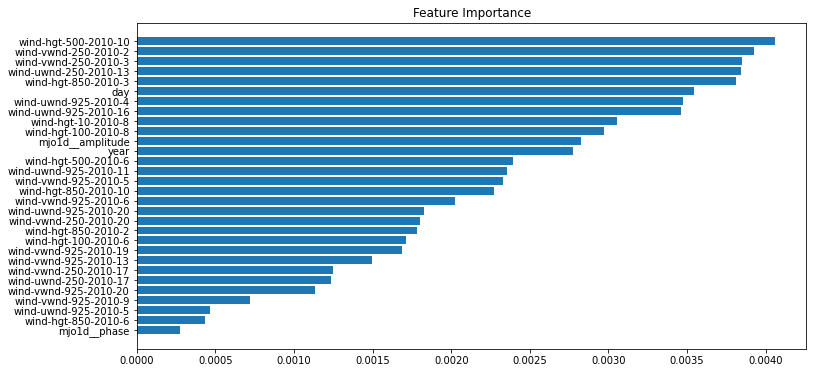

In [80]:
feature_importance = reg_catb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx))[:30], feature_importance[sorted_idx][:30], align='center')
plt.yticks(range(len(sorted_idx))[:30], np.array(X_test.columns)[sorted_idx][:30])
plt.title('Feature Importance')

In [75]:
np.array(X_test.columns)[sorted_idx][:15]

array(['wind-uwnd-250-2010-17', 'month', 'wind-hgt-500-2010-5', 'day',
       'wind-vwnd-925-2010-6', 'sst-2010-9', 'sst-2010-7',
       'wind-uwnd-925-2010-18', 'wind-uwnd-250-2010-14',
       'wind-vwnd-925-2010-5', 'wind-hgt-10-2010-10',
       'wind-vwnd-925-2010-4', 'wind-vwnd-250-2010-12', 'sst-2010-3',
       'icec-2010-6'], dtype=object)

In [76]:
reg_catb.get_feature_importance()

array([3.47603395e+00, 3.24077385e+00, 4.19596306e+00, 4.33436002e-02,
       5.36285922e-02, 6.11369626e-02, 3.37173822e-02, 2.52096064e-02,
       7.44374730e-02, 6.51050902e-02, 5.32228085e-02, 9.07674115e-02,
       8.02432621e-03, 2.77007500e-02, 1.31544997e-02, 5.53778113e-02,
       4.01276719e-02, 1.05596743e+00, 7.05575547e+00, 3.23202188e-02,
       9.46775506e+00, 7.27871972e+00, 2.68170933e+00, 2.01671248e+00,
       2.45327091e-01, 8.96912412e-02, 5.69022739e-02, 6.52868064e-02,
       2.76420816e-02, 6.50776207e-02, 4.35815967e-02, 4.58172333e-02,
       2.77311675e-02, 7.02347623e-02, 3.50670226e-02, 1.48422453e+00,
       4.89761457e-02, 4.96251196e-02, 8.68572525e-02, 5.14611498e-02,
       4.24908315e-02, 4.30583701e-02, 5.55063893e-02, 1.23193654e-01,
       6.65039172e-02, 4.41595886e-02, 6.94547735e-02, 5.18719839e-02,
       1.21362841e-01, 9.35360133e-02, 3.90247570e-02, 3.70809456e-02,
       9.29681950e-02, 8.26372143e-02, 5.34268368e-02, 3.07600171e-02,
      

In [77]:
cc_test_pred_cat = reg_catb.predict(cc_test_reduced)

In [78]:
cc_test_copy_cat = cc_test.copy()

In [79]:
cc_test_copy_cat[target] = cc_test_pred_cat
cc_test_copy_cat[[target,"index"]].to_csv("cat_predictions_mxb_260223_version5.csv",index = False)

In [80]:
from google.colab import files
files.download('/content/cat_predictions_mxb_260223_version5.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
files.download('/content/reg_catb_w_feat_importance')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>